<center> <h1> Diagnose Latent Cytomegalovirus Using CyTOF Data and Deep Learning <h1> </center>

<center>Zicheng Hu, Ph.D.</center>
<center>Research Scientist</center>
<center>ImmPort Team</center>
<center>The Unversity of California, San Francisco</center>

![alt text](Data/header.png)

In [1]:
%matplotlib inline

In [2]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
import keras_tuner as kt

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
phenotype = 'Subject Age'

In [5]:
##### Step 2: load data #####

tutorial_files = ! ls Data
if "allData.obj" not in tutorial_files:
    print("Downloading Data:")
    ! wget https://ucsf.box.com/shared/static/tn8m9hco3f3gugn7z394yzimvtfdg129.obj -O ./Data/allData.obj
        
#load data
with open("FCS_to_Array/agingData.obj", "rb") as f:
    allData = pickle.load(f)
metaData = allData["samples"].reset_index().drop(columns='Unnamed: 0')
cytoData = allData['expr_list']
markerNames = allData["marker_names"]

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the makers: \n",markerNames.values)

Dimensions of cytoData:  (753, 20000, 13, 1) 

Names of the makers: 
 ['FSC-A' 'FSC-H' 'FSC-W' 'SSC-A' 'SSC-H' 'SSC-W' 'PSTAT1' 'PSTAT5' 'CD66B'
 'CD33' 'CD3/CD14' 'PSTAT3' 'CD4/CD19']


In [6]:
##### Step 3: split train, validation and test######
phenotype = 'Subject Age'
stimulation = 'interferon alpha'
x = []
y = []
for i, row in metaData[(metaData['Expsample Treatement']==stimulation) & (metaData['Age Unit']=='Years')].iterrows():
    x.append(cytoData[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

In [7]:
def model_builder(hp):
    hp_filters_l1 = hp.Int('filters_l1', min_value=3, max_value=15, step=3)
    hp_filters_l2 = hp.Int('filters_l2', min_value=3, max_value=15, step=3)
    model = Sequential([
        Input(shape=x[0].shape),
        Conv2D(hp_filters_l1, kernel_size = (1, x.shape[2]), activation=None),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(hp_filters_l2, kernel_size = (1,1), activation=None),
        BatchNormalization(),
        Activation('relu'),
        AveragePooling2D(pool_size = (x.shape[1], 1)),
        Flatten(),
        Dense(hp_filters_l2, activation=None),
        BatchNormalization(),
        Activation('relu'),
        Dense(1, activation=None),
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        loss=MeanAbsoluteError(),
        optimizer=Adam(learning_rate=hp_learning_rate),
        metrics=['mean_absolute_error'],
    )
    return model

In [8]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     overwrite=True,
#                      directory='hp-search',
#                      project_name='aging_regression',
                    )

In [9]:
tuner.search(
    x_train, y_train,
#     epochs=50,
    validation_split=0.2,
#     callbacks=[stop_early]
)

Trial 67 Complete [00h 00m 01s]
val_mean_absolute_error: 0.358440637588501

Best val_mean_absolute_error So Far: 0.2523493468761444
Total elapsed time: 00h 01m 41s
INFO:tensorflow:Oracle triggered exit


In [10]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'filters_l1={best_hps["filters_l1"]}')
print(f'filters_l2={best_hps["filters_l2"]}')
print(f'learning_rate={best_hps["learning_rate"]}')

filters_l1=6
filters_l2=6
learning_rate=0.01


In [22]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20000, 1, 6)       84        
_________________________________________________________________
batch_normalization (BatchNo (None, 20000, 1, 6)       24        
_________________________________________________________________
activation (Activation)      (None, 20000, 1, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20000, 1, 6)       42        
_________________________________________________________________
batch_normalization_1 (Batch (None, 20000, 1, 6)       24        
_________________________________________________________________
activation_1 (Activation)    (None, 20000, 1, 6)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 6)           0

In [23]:
# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = 1/age_range)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=250, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/250
2/2 [==============================] - 1s 250ms/step - loss: 0.6189 - mean_absolute_error: 0.6189 - val_loss: 0.4870 - val_mean_absolute_error: 0.4870
Epoch 2/250
2/2 [==============================] - 0s 81ms/step - loss: 0.5182 - mean_absolute_error: 0.5182 - val_loss: 0.3709 - val_mean_absolute_error: 0.3709
Epoch 3/250
2/2 [==============================] - 0s 82ms/step - loss: 0.4436 - mean_absolute_error: 0.4436 - val_loss: 0.3099 - val_mean_absolute_error: 0.3099
Epoch 4/250
2/2 [==============================] - 0s 82ms/step - loss: 0.3868 - mean_absolute_error: 0.3868 - val_loss: 0.2882 - val_mean_absolute_error: 0.2882
Epoch 5/250
2/2 [==============================] - 0s 83ms/step - loss: 0.3522 - mean_absolute_error: 0.3522 - val_loss: 0.2783 - val_mean_absolute_error: 0.2783
Epoch 6/250
2/2 [==============================] - 0s 76ms/step - loss: 0.3052 - mean_absolute_error: 0.3052 - val_loss: 0.2874 - val_mean_absolute_error: 0.2874
Epoch 7/250
2/2 [==========

In [24]:
rt

30.69461417198181

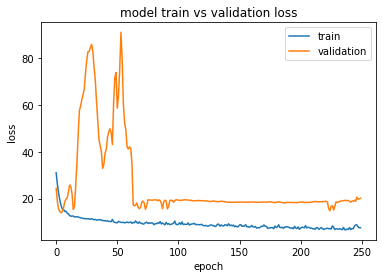

In [25]:
##### Step 6: plot train and validation loss #####
plt.plot(age_range*pd.Series(model.history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(model.history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

count    38.000000
mean     61.636719
std       2.202550
min      54.094822
25%      60.731437
50%      61.912483
75%      63.208785
max      64.917572
dtype: float64


<AxesSubplot:ylabel='Frequency'>

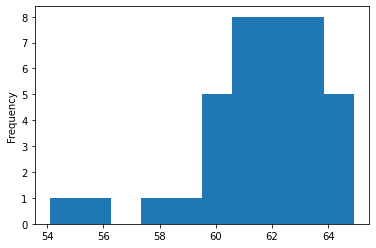

In [15]:
#### Step 7: test the final model #####

# load final model
# final_model = load_model('Data/Final_weights.hdf5')
final_model = model

# generate ROC and AUC
y_scores = age_range*pd.Series([_[0] for _ in final_model.predict([x_valid])])
y_scores
# y_test
# y_scores.reshape(y_scores.shape[0])
# y_scores = age_range * pd.Series(y_scores.reshape(y_scores.shape[0]))
print(y_scores.describe())
y_scores.plot.hist()